<a href="https://colab.research.google.com/github/khaophuthaipch/EAI6000/blob/master/Assignment_3_Street_View_House_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pimchanok Khaophuthai
# EAI6000
# Mar 9, 2020

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [2]:
%matplotlib inline
!pip install openml # Uncomment to run in Google Colab
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import time

     |████████████████████████████████| 163kB 2.9MB/s 
  Created wheel for openml: filename=openml-0.10.2-cp36-none-any.whl size=190318 sha256=a3de8467eb7358ff193d8f21e9c0ae936d12a33cdff47b5a734998c86fb66714
  Stored in directory: /root/.cache/pip/wheels/71/ec/5f/aaad9e184680b0b8f1a02ff0ec640cace5adf5bff7bb0af1b4
  Created wheel for liac-arff: filename=liac_arff-2.4.0-cp36-none-any.whl size=13335 sha256=4dd0d5297f1c2d1d2b0b2b2037792e049efcf20b12cfb97f72608eb70fc108c2
  Stored in directory: /root/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5203
Successfully built openml liac-arff


In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

In [0]:
# To save time, you can save the dataset to a Google drive, and load it quickly later
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "wb") as f:
    pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
    pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# (Uncomment to) Load SVHN dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "rb") as f:
    X = pickle.load(f)
    y = pickle.load(f)
    cats = pickle.load(f)
    attrs = pickle.load(f)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [4]:
X.shape

(99289, 3072)

There are 99289 image. Each image has 32*32 pixel and it is RGB color therefore the features is 32 * 32 * 3 = 3072

### You can use the following function to plot the first 10 images to get a sense of the data.

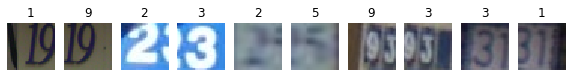

In [5]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

### Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

In [0]:
# A function to convert RGB image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [0]:
# Convert to grayscale
X_gray = rgb2gray(X.reshape(99289,32,32,3))
X_gray = X_gray.reshape(99289,-1)
# Normalized to range 0 to 1
X_gray = X_gray.astype('float')
X_gray /= 255.0


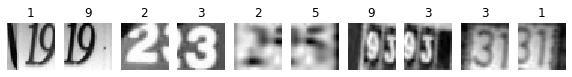

In [8]:
plot_images(X_gray[:10], y[:10], grayscale=True)

### Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

In [0]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 1% stratified subsample
Xs, _, ys, _ = train_test_split(X_gray, y, stratify=y, train_size=0.01)

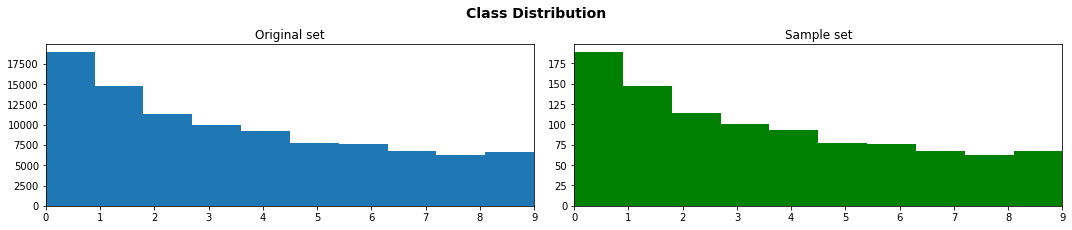

In [10]:
# Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. 
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(15,3))

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y, bins=10)
ax1.set_title("Original set")
ax1.set_xlim(0, 9)

ax2.hist(ys, color='g', bins=10)
ax2.set_title("Sample set")

fig.tight_layout()

##### Evaluate Linear Learners with 1% subsample data, 3 folds cross validation

In [0]:
def evaluate_learners(classifiers, X, y, fold = None):
    """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data. 
    
    Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
     - a list with the scores obtained on the training samples for each classifier,
     - a list with the test scores obtained on the test samples for each classifier.
     The order of scores should match the order in which the classifiers were originally provided. E.g.:     
     [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
    """
    score = [cross_validate(c, X, y, cv = fold ,return_train_score=True,) for c in classifiers]
    train_scores = [s['train_score'] for s in score]
    test_scores = [s['test_score'] for s in score]
    return train_scores, test_scores


In [12]:
start_time = time.time()

classifiers = [LogisticRegression(max_iter = 1000, solver = 'saga'),
               LinearSVC(),
               KNeighborsClassifier()]
train_scores, test_scores = evaluate_learners(classifiers, Xs , ys, fold=3)

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of itera

--- 148.46468091011047 seconds ---


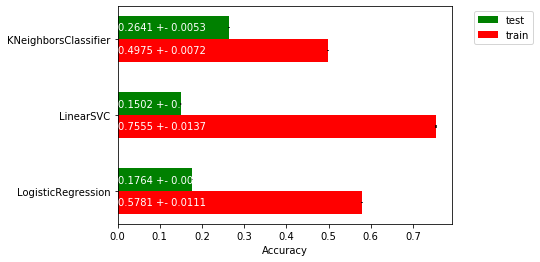

In [13]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars

fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

#### Discuss the result
It takes almost 3 minutes to train the linear models with 1% of data. All the models accuracy is below 25%. As the dataset is complex, training with 1% of the data underfits the models as expected, observable by large gap between training accuracy and testing accuracy. Using more data should help increasing the accuracy but it will take more time to train. Additionally, considering a more complex model to capture the complexity in the data also helps achieving bettter accuracy since the dataset.

In [0]:
#Evaluate the same models using 3% of the data. 
Xs, _, ys, _ = train_test_split(X_gray, y, stratify=y, train_size=0.03)

In [15]:
import time
start_time = time.time()

classifiers = [LogisticRegression(max_iter = 1000, solver = 'saga'),
               LinearSVC(),
               KNeighborsClassifier()]
train_scores, test_scores = evaluate_learners(classifiers, Xs , ys, fold=3)

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of itera

--- 508.17525815963745 seconds ---


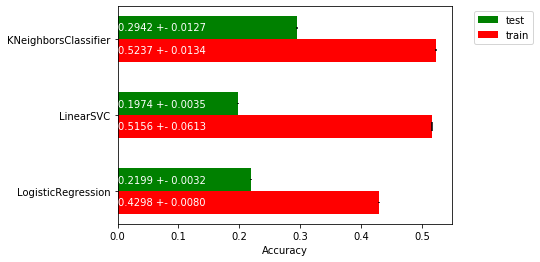

In [16]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

With 3% data, the run time is longer as expected, it takes around 9.30 mins to train. KNeighbotsClassifier has the most improvement in accuracy from 0.24 to 0.31. LinearSVC and LogisticRegresiion accuracy improve by just a few point. As observed with 1% data, the linear models perform poorly with the highest accuracy just 0.29. Underfitting stil exists but with the time it takes to train and evaluate, using more data may not be appropriate, we can alternatively use more complex model like neural network instead of the linear, using all the data and get higher accuracy with lower running time.

### Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


In [17]:
X_gray.shape

(99289, 1024)

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Set up model layers
model = Sequential()
model.add(Dense(256, activation='relu', input_shape = (1024,)))
model.add(Dense(10))

In [19]:
# Compile the model
model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 264,970
Trainable params: 264,970
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train test data 80/20
X_train, X_test, y_train, y_test = train_test_split(X_gray, y, test_size = 0.2, random_state = 43)

In [21]:
start_time = time.time()
with tf.device('/device:GPU:0'):
  model_trained = model.fit(X_train, y_train, batch_size = 128, epochs=20, verbose = 2, validation_data= (X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

Train on 79431 samples, validate on 19858 samples
Epoch 1/20
79431/79431 - 4s - loss: 2.0800 - accuracy: 0.2671 - val_loss: 1.7826 - val_accuracy: 0.3885
Epoch 2/20
79431/79431 - 2s - loss: 1.5295 - accuracy: 0.5115 - val_loss: 1.3880 - val_accuracy: 0.5737
Epoch 3/20
79431/79431 - 2s - loss: 1.2916 - accuracy: 0.6027 - val_loss: 1.2427 - val_accuracy: 0.6196
Epoch 4/20
79431/79431 - 2s - loss: 1.1855 - accuracy: 0.6406 - val_loss: 1.1499 - val_accuracy: 0.6567
Epoch 5/20
79431/79431 - 2s - loss: 1.1178 - accuracy: 0.6651 - val_loss: 1.0932 - val_accuracy: 0.6781
Epoch 6/20
79431/79431 - 2s - loss: 1.0715 - accuracy: 0.6788 - val_loss: 1.0791 - val_accuracy: 0.6728
Epoch 7/20
79431/79431 - 2s - loss: 1.0341 - accuracy: 0.6910 - val_loss: 1.0468 - val_accuracy: 0.6931
Epoch 8/20
79431/79431 - 2s - loss: 1.0104 - accuracy: 0.6965 - val_loss: 1.0188 - val_accuracy: 0.6994
Epoch 9/20
79431/79431 - 2s - loss: 0.9923 - accuracy: 0.7031 - val_loss: 1.0099 - val_accuracy: 0.7014
Epoch 10/20
79

In [90]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

19858/19858 - 1s - loss: 0.9422 - acc: 0.7232


#### Evaluate the accuracy with 80/20, compare with Linear models

It take less than 1 minute to train the model with 20 epoch and the accuracy is at 0.72. Comparing to the linear models, Neural Network is far more efficient and has better ability to learn the complexity in the dataset.

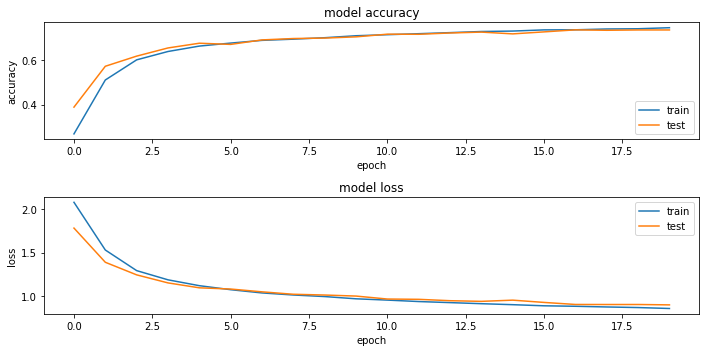

In [23]:
fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(model_trained.history['accuracy'])
plt.plot(model_trained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
class_predictions = model.predict_classes(X_test)
prediction_probabilities = probability_model.predict(X_test)


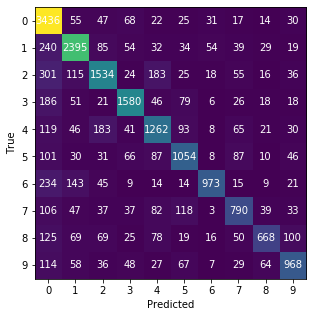

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,class_predictions)
fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
# ax.set_xticklabels(class_names, rotation=45, ha="right")
# ax.set_yticklabels(class_names)
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

#### Confusion matrix
The model often predicts "0" for other digits having "2" as the highest incorrect prediction followed by 0, 6 and 1. 7, 8 and 9 are often incorrectly predicted.

In [0]:
# misclassified 
misclassified = [x for t in np.where(y_test != class_predictions) for x in t]
correct_classified = [x for t in np.where(y_test == class_predictions) for x in t]

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label+1,
                                100*np.max(predictions_array),
                                true_label+1),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([1,2,3,4,5,6,7,8,9,0],rotation=90)
  plt.yticks([])
  thisplot = plt.bar([1,2,3,4,5,6,7,8,9,0], predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

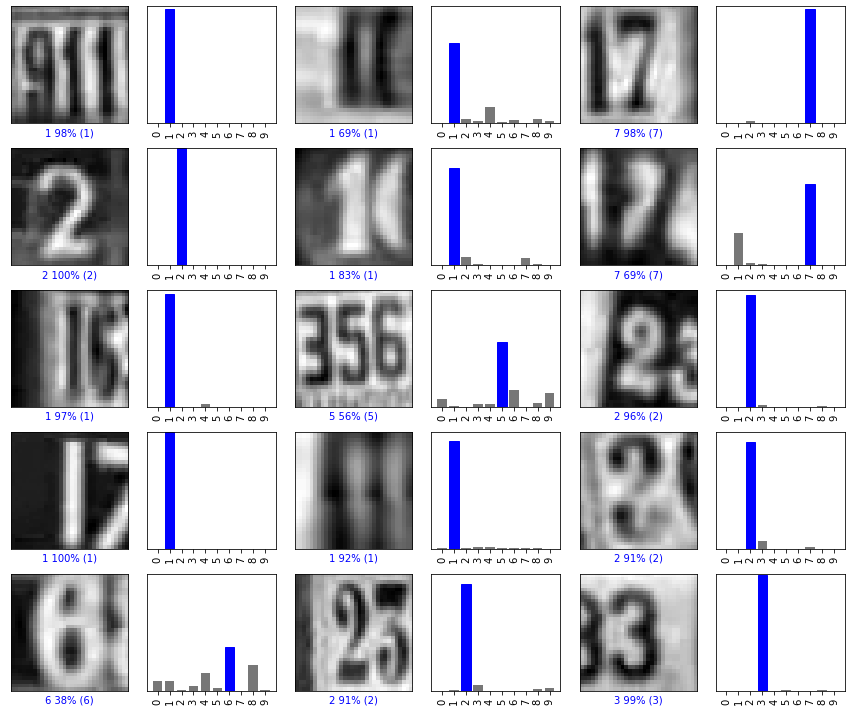

In [28]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(correct_classified[i], prediction_probabilities[correct_classified[:15]][i], y_test, X_test.reshape(19858,32,32))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(correct_classified[i], prediction_probabilities[correct_classified[:15]][i], y_test)
plt.tight_layout()
plt.show()

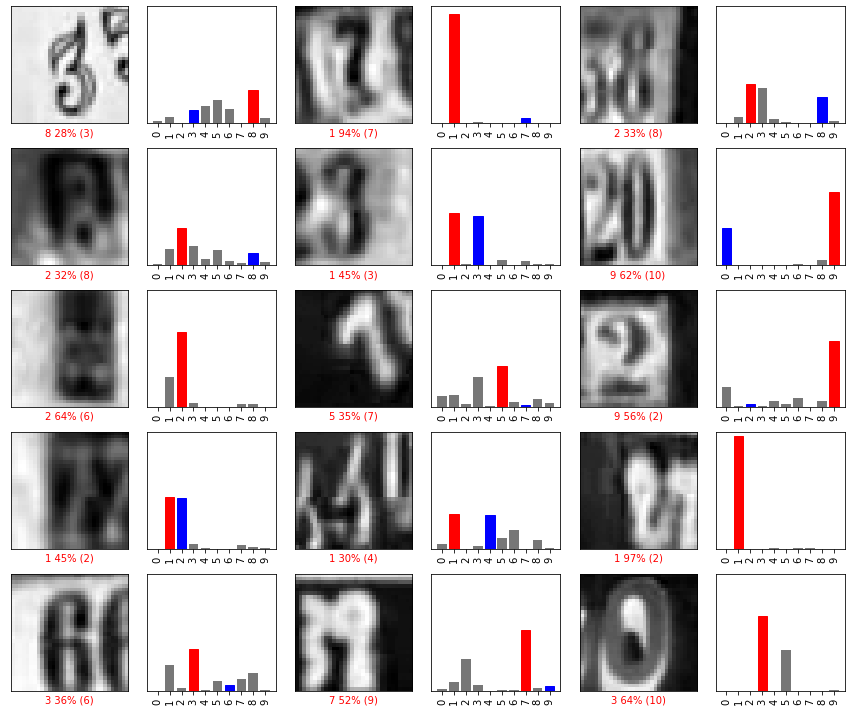

In [29]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(misclassified[i], prediction_probabilities[misclassified[:15]][i], y_test, X_test.reshape(19858,32,32))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(misclassified[i], prediction_probabilities[misclassified[:15]][i], y_test)
plt.tight_layout()
plt.show()

#### Misclassification plot
What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?

Errors are often made with the numbers that are slanted, blurred and disconnected line. These are the hard ones. Some numbers are even hard for human to classify. For instance the frist two columns of the last row,I would not see that picture as a 4 and 2, so I would not expect that the model would get this correct.

## Bonus

Bonus challenge: 
Can you improve the model performance from this first Keras model?
If you wonder about how researchers get to 98% accuracy, here is a list of papers :)
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e 

## CNN Architecture

In [0]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size = 0.2)

In [0]:
X_train_cnn, X_train_cnn = X_train_cnn / 255.0, X_train_cnn / 255.0

In [0]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))

In [33]:
model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(10))

In [35]:
model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [0]:
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [38]:
with tf.device('/device:GPU:0'):
  history = model_cnn.fit(X_train_cnn.reshape(79431,32,32,3), y_train_cnn, epochs=20, 
                          validation_data=(X_test_cnn.reshape(19858,32,32,3), y_test_cnn))

Train on 79431 samples, validate on 19858 samples
Epoch 1/20
79431/79431 [==============================] - 21s 268us/sample - loss: 0.9006 - accuracy: 0.7141 - val_loss: 39.4277 - val_accuracy: 0.8478
Epoch 2/20
79431/79431 [==============================] - 16s 205us/sample - loss: 0.4368 - accuracy: 0.8728 - val_loss: 31.5131 - val_accuracy: 0.8626
Epoch 3/20
79431/79431 [==============================] - 16s 205us/sample - loss: 0.3645 - accuracy: 0.8942 - val_loss: 26.6141 - val_accuracy: 0.8781
Epoch 4/20
79431/79431 [==============================] - 18s 222us/sample - loss: 0.3186 - accuracy: 0.9075 - val_loss: 31.4296 - val_accuracy: 0.8421
Epoch 5/20
79431/79431 [==============================] - 18s 227us/sample - loss: 0.2911 - accuracy: 0.9151 - val_loss: 28.3419 - val_accuracy: 0.8458
Epoch 6/20
79431/79431 [==============================] - 18s 228us/sample - loss: 0.2674 - accuracy: 0.9211 - val_loss: 26.5018 - val_accuracy: 0.8769
Epoch 7/20
79431/79431 [==============

In [44]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn.reshape(19858,32,32,3),  y_test_cnn, verbose=2)

19858/19858 - 2s - loss: 75.7234 - accuracy: 0.8497


In [45]:
print(test_acc)

0.8497331


In [0]:
probability_model_cnn = tf.keras.Sequential([model_cnn, 
                                         tf.keras.layers.Softmax()])
class_predictions_cnn = model_cnn.predict_classes(X_test_cnn.reshape(19858,32,32,3))
prediction_probabilities_cnn = probability_model_cnn.predict(X_test_cnn.reshape(19858,32,32,3))


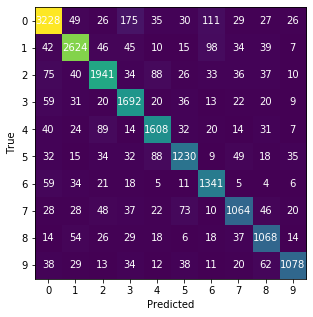

In [49]:
cm = confusion_matrix(y_test_cnn,class_predictions_cnn)
fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
# ax.set_xticklabels(class_names, rotation=45, ha="right")
# ax.set_yticklabels(class_names)
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

CNN obtains accuracy of 0.8497 which is higher than NN model. I believe improving on architecture of CNN will help with the performance.